# Utility functions


In [1]:
%matplotlib inline
from nltk.cluster.kmeans import KMeansClusterer
import nltk
import pickle

import torch
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertModel
from pytorch_pretrained_bert.modeling import BertPreTrainedModel, BertPreTrainingHeads
import numpy as np
from scipy.spatial.distance import cosine
import pickle
import re
import pandas as pd
device = 'cpu'
import sys
import os
import iso8601
from datetime import datetime

import json


In [2]:
class BertForPreTraining_custom(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForPreTraining_custom, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None, next_sentence_label=None):
        output_all_encoded_layers=True
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                                   output_all_encoded_layers=output_all_encoded_layers)
        if output_all_encoded_layers:
            sequence_output_pred = sequence_output[-1]
        prediction_scores, seq_relationship_score = self.cls(sequence_output_pred, pooled_output)
        return prediction_scores, seq_relationship_score, sequence_output, pooled_output 
    
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_json_file('../data/bert_config.json')
bert_model = 'bert-base-uncased'

In [24]:
def getNSPScore(sample_text):
    
    m = torch.nn.Softmax()

    tokenized_text = tokenizer.tokenize(sample_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    segments_ids = [0]*tokenized_text.index('[SEP]')+[1]*(len(tokenized_text)-tokenized_text.index('[SEP]'))

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    pred_score, seq_rel, seq_out, pool_out = model1(tokens_tensor, segments_tensors)
    return m(seq_rel).detach().numpy()[0][0] #returns probability of being next sentence

def getSentMatchScore(sent1, sent2, nsp_dampening_factor = 0.7):
    
    sent1_feats = getBERTFeatures(model1, sent1, attn_head_idx)
    sent2_feats = getBERTFeatures(model1, sent2, attn_head_idx)
    
    cosine_distance = 1- cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    nsp_score_2 = getNSPScore(nsp_input2)
    nsp_score = np.mean([nsp_score_1,nsp_score_2])*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    #print ("nsp score -> " + str(nsp_score))
    #print ("cosine score -> " + str(cosine_distance))
    return score
    

def getSentMatchScore_wfeature(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    #nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    #nsp_score_2 = getNSPScore(nsp_input2)
    
    nsp_score = nsp_score_1 * nsp_dampening_factor
    #nsp_score = nsp_score_1*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    return score

def getSentMatchScore_wfeature_cosine(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    return cosine_distance
    

def getBERTFeatures(model, text, attn_head_idx = -1): #attn_head_idx - index o[]
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text)>200:
        tokenized_text = tokenized_text[0:200]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    _, _, seq_out, pool_out = model(tokens_tensor)
    seq_out = list(getPooledFeatures(seq_out[attn_head_idx]).T)
    #pool_out = list(pool_out.detach().numpy().T)
    
    return seq_out

def getPooledFeatures(np_array):
    np_array = np_array.reshape(np_array.shape[1],np_array.shape[2]).detach().numpy()
    np_array_mp = np.mean(np_array, axis=0).reshape(1, -1)
    return np_array_mp

def replaceContractions(text):
    #text = text.lower()
    c_filt_text = ''
    for word in text.split(' '):
        if word in contractions:
            c_filt_text = c_filt_text+' '+contractions[word]
        else:
            c_filt_text = c_filt_text+' '+word
    return c_filt_text

def cleanText(text):
        
    text = text.replace('\\n','')
    text = text.replace('\\','')
    #text = text.replace('\t', '')
    #text = re.sub('\[(.*?)\]','',text) #removes [this one]
    text = re.sub('(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?\s',
                ' __url__ ',text) #remove urls
    #text = re.sub('\'','',text)
    #text = re.sub(r'\d+', ' __number__ ', text) #replaces numbers
    text = re.sub('\W', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.replace('\t', '')
    text = text.replace('\n', '')
    return text

def formatTime(tz_time, datetime_object=False):
    isoTime = iso8601.parse_date(tz_time)
    ts = isoTime.timestamp()
    ts = datetime.utcfromtimestamp(ts).strftime("%Y-%m-%d %H:%M:%S:%f")

    if datetime_object:
        ts = datetime.fromisoformat(ts)
    return ts


In [79]:
c_text = "So one thing we can try is take the same domain names and join as a user to accept a PICC lines on the back end if you want to initialize a conference.Right so that we can spend one and I can say hey this is the last nominee nominee is a number of last in chance really to create because it is you are allocating a room in Trinity.So one thing we can try is take the same domain names and join as a user to accept a PICC lines on the back end if you want to initialize a conference.Right so that we can spend one and I can say hey this is the last nominee nominee is a number of last in chance really to create because it is you are allocating a room in Trinity."
c_fv = getBERTFeatures(model1, "Were going to be talking about why is many people as possible should be learning sequel or stand structure through we language and it is the primary language responsible for managing data and data structures contained within relational database systems.", attn_head_idx = -1)
c_fv2 = getBERTFeatures(model1, "a circle call everything we can to is going to be is easy that so just turn it and we are going it short two", attn_head_idx = -1)
#getSentMatchScore_wfeature(c_text, c_text, c_fv, c_fv2, nsp_dampening_factor = 0.7)
1-cosine(c_fv,c_fv2)

0.7972765564918518

In [25]:
model1 = BertForPreTraining_custom(config)
model1.to(device)
#state_dict_1 = torch.load('../data/bert_10epc_inc_se+etherdata_1e-6_sl40_bt64.bin')
state_dict_1 = torch.load('../data/bert_10epc_se_1e-6_sl40.bin')
model1.load_state_dict(state_dict_1)
model1.eval()

BertForPreTraining_custom(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): 

# Parsing Meetings

## Timeline json meeting Input (NA)

In [139]:
def parsemeeting(text):
    with open(text, 'r') as f:
        parsed_text = json.load(f)
    return parsed_text
text = parsemeeting('../data/timeline_result2.json')

In [140]:
texts = ''
temp = ' '
for t in text['timeline']['transcriptSegments']:
    temp = ' ' +  t['text']
    texts = texts + temp
    

In [ ]:
## Get top 10 pims instead of all the segments.    
# texts = ''
# temp = ' '
# for t in text['segments']:
#     if t['transcriber'] == "google_speech_api":
#         temp = ' ' +  t['originalText']
#         print ("---text-----  \n\nspoken by: " + t['spokenBy'] + "\n")
#         print (temp, "\n\n\n")
#         texts = texts + temp
    

## Load meeting as csv and get only the top10 pims.

In [26]:
## load it as csv.
import pandas

df = pandas.read_csv('../data/subtopic_010.csv', index_col=False, header=0);
df = df.sort_values(by='created_at')

In [67]:
import json
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp
data= {}
curl_test = {}
segment_contents = {}
texts = ''
curl_test["contextId"] ="6baa3490-69d6-48fc-b5d4-3994e3e8fae0"
curl_test["mindId"] = "01daayheky5f4e02qvrjptftxv"
curl_test["segments"] = []
for index,segment in enumerate(df['value'].tolist()):
    data = json.loads(segment)
    if "google" not in data['transcriber'] and data['originalText']!='':
        #print (str(index)+"\t"+data['originalText'], end="\n\n\n")
        curl_test['segments'].append(json.loads(segment))
        texts+= (' ' + data['originalText'])
        segment_contents[index]= [' '.join(tp.preprocess(data['originalText'], stop_words=False, remove_punct=False)),formatTime(data['startTime'], True), data['spokenBy']]
        

0	We're going to be talking about why is many people as possible should be learning sequel or stand structure through we language and it's the primary language responsible for managing data and data structures contained within relational database systems. So anytime you're trying to retrieve data from a database and data database or make any modifications the data structures you're probably going to using some there of the sequel or T language. Let's dig into the first reason why I believe you should our sequel first turn some great body the potential for somebody with strong seamless skills. That's pretty significant again if you're a financial a**lyst or anybody who who's excel guru but lacks the sequel knowledge learning sequel might be the next step for you to really progress your career and I get to find opportunity for a high job along with the higher potential see sought after skills by that are hiring this makes sense given the on a**lytics and the growth of data. So wouldn't a

# get Communities from meetings.

In [68]:
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp


mod_texts_unfiltered = tp.preprocess(texts, stop_words=False, remove_punct=False)
mod_texts = []

for index, sent in enumerate(mod_texts_unfiltered):
    if len(sent.split(' '))>250:
        length = len(sent.split(' '))
        split1 = ' '.join([i for i in sent.split(' ')[:round(length/2)]])
        split2 = ' '.join([i for i in sent.split(' ')[round(length/2):]])
        mod_texts.append(split1)
        mod_texts.append(split2)
        continue
        #mod_texts.pop(index)
#     if len(sent.split(' '))<=6:
#         continue
    mod_texts.append(sent)

print(len(mod_texts))
fv = {}

for index, sent in enumerate(mod_texts):
    fv[index] = getBERTFeatures(model1, sent, attn_head_idx=-1)
    print (index)

62
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


In [71]:
# for index1, sent1 in enumerate(mod_texts):
#     for index2, sent2 in enumerate(mod_texts):
#         print ("Sentence 1:\n " + sent1 + "\nSentence 2:\n " + sent2 + "\n Cosine score:" + str(1-cosine(fv[index1],fv[index2])), end="\n\n\n")

Sentence 1:
 Were going to be talking about why is many people as possible should be learning sequel or stand structure through we language and it is the primary language responsible for managing data and data structures contained within relational database systems.
Sentence 2:
 Were going to be talking about why is many people as possible should be learning sequel or stand structure through we language and it is the primary language responsible for managing data and data structures contained within relational database systems.
 Cosine score:1.0


Sentence 1:
 Were going to be talking about why is many people as possible should be learning sequel or stand structure through we language and it is the primary language responsible for managing data and data structures contained within relational database systems.
Sentence 2:
 So anytime you are trying to retrieve data from a database and data database or make any modifications the data structures you are probably going to using some there 

Sentence 1:
 If you are somebody works in excel how many times have you work the really big spreadsheet try to create some formula reviews some operation and excel crashes yes got better renewal but.
Sentence 2:
 For and it is a great course to get toes into learning sequel and we tried break it down and make it very, very simple.
 Cosine score:0.8434526324272156


Sentence 1:
 If you are somebody works in excel how many times have you work the really big spreadsheet try to create some formula reviews some operation and excel crashes yes got better renewal but.
Sentence 2:
 So I will I include that link you can find it on our website very different places.
 Cosine score:0.8332540392875671


Sentence 1:
 If you are somebody works in excel how many times have you work the really big spreadsheet try to create some formula reviews some operation and excel crashes yes got better renewal but.
Sentence 2:
 So you out for that and you are interested learning highly recommend you take a look th

Sentence 1:
 It is one of the most in demand skills.
Sentence 2:
 The number of Servers.
 Cosine score:0.7532511949539185


Sentence 1:
 It is one of the most in demand skills.
Sentence 2:
 She needs to constantly growing because her company continues to launch new products and customers are consuming more of their services.
 Cosine score:0.7749520540237427


Sentence 1:
 It is one of the most in demand skills.
Sentence 2:
 This increase of services has caused some challenges for the tools that you use to investor of these servers or not as effective would use to as much larger volume servers.
 Cosine score:0.7673871517181396


Sentence 1:
 It is one of the most in demand skills.
Sentence 2:
 This challenge affects how do coded deploy in her production environment usually with new employees release.
 Cosine score:0.7807452082633972


Sentence 1:
 It is one of the most in demand skills.
Sentence 2:
 It takes a little production take to the production environment.
 Cosine score:0.7713942

Sentence 1:
 So you out for that and you are interested learning highly recommend you take a look that that is it for that.
Sentence 2:
 I think just working visibility right.
 Cosine score:0.7831827998161316


Sentence 1:
 So you out for that and you are interested learning highly recommend you take a look that that is it for that.
Sentence 2:
 Sometimes turn the pipe try it in my mind and just on mind.
 Cosine score:0.8541907668113708


Sentence 1:
 So you out for that and you are interested learning highly recommend you take a look that that is it for that.
Sentence 2:
 I could not remember start.
 Cosine score:0.7874276041984558


Sentence 1:
 So you out for that and you are interested learning highly recommend you take a look that that is it for that.
Sentence 2:
 I stopped then it we got near to be termination how I thought to myself I am never gonna to remember any things.
 Cosine score:0.8692934513092041


Sentence 1:
 So you out for that and you are interested learning highly 

Sentence 1:
 I stopped then it we got near to be termination how I thought to myself I am never gonna to remember any things.
Sentence 2:
 That is pretty significant again if you are a financial alyst or anybody who who is excel guru but lacks the sequel knowledge learning sequel might be the next step for you to really progress your career and I get to find opportunity for a high job along with the higher potential see sought after skills by that are hiring this makes sense given the on alytics and the growth of data.
 Cosine score:0.8166866898536682


Sentence 1:
 I stopped then it we got near to be termination how I thought to myself I am never gonna to remember any things.
Sentence 2:
 So would not apply as that are looking for more more individuals with have talent to a tree data on a database using sheet and know what to do with it along with the career audience and reasons for learning another reason that you might want want to see is because it enables you to get an answer to a

Sentence 1:
 This time looking in this way and the knows and this time let us still a different expression circle which we can shave in and we got a expression.
Sentence 2:
 I also thought to myself that must be at must there and that means because if we take that information and we can turn into a picture when the join we in that right because when we draw but can they are trouble with that people say that is a great idea but I cannot draw but I will believe everybody can draw something well to make the only november and today I tried to show you how to do we are going to start building up our visual with bursting that circle.
 Cosine score:0.8974888920783997


Sentence 1:
 This time looking in this way and the knows and this time let us still a different expression circle which we can shave in and we got a expression.
Sentence 2:
 So can get paper for that have a good.
 Cosine score:0.8860020637512207


Sentence 1:
 This time looking in this way and the knows and this time let us sti

Sentence 1:
 Couple the that way something different on the top and next frame this way that way got that.
Sentence 2:
 So what can be done to help and work better.
 Cosine score:0.8004304766654968


Sentence 1:
 Couple the that way something different on the top and next frame this way that way got that.
Sentence 2:
 Ultimately they want the same thing happy customers.
 Cosine score:0.8190243244171143


Sentence 1:
 Couple the that way something different on the top and next frame this way that way got that.
Sentence 2:
 What is deep developer and operations were better together not more like broke down share responsibility this would harder them to change their mindset on top dev and work.
 Cosine score:0.871504008769989


Sentence 1:
 Couple the that way something different on the top and next frame this way that way got that.
Sentence 2:
 So what is Dev integration developers and operations teams in order to improve collaboration and productivity by automated infrastructure automat

Sentence 1:
 That is going to be a tribe next say what saying we could that into hmmm what sure we take it here it looks fine both with another at a little nine on.
Sentence 2:
 Couple the that way something different on the top and next frame this way that way got that.
 Cosine score:0.9086605906486511


Sentence 1:
 That is going to be a tribe next say what saying we could that into hmmm what sure we take it here it looks fine both with another at a little nine on.
Sentence 2:
 Let is go over this way three and you got so to the top.
 Cosine score:0.8019112944602966


Sentence 1:
 That is going to be a tribe next say what saying we could that into hmmm what sure we take it here it looks fine both with another at a little nine on.
Sentence 2:
 Now this floor align and then another line.
 Cosine score:0.8317381739616394


Sentence 1:
 That is going to be a tribe next say what saying we could that into hmmm what sure we take it here it looks fine both with another at a little nine on.
S

Sentence 1:
 She needs to constantly growing because her company continues to launch new products and customers are consuming more of their services.
Sentence 2:
 If you are somebody works in excel how many times have you work the really big spreadsheet try to create some formula reviews some operation and excel crashes yes got better renewal but.
 Cosine score:0.7702203392982483


Sentence 1:
 She needs to constantly growing because her company continues to launch new products and customers are consuming more of their services.
Sentence 2:
 But happen he eliminate that crashing by writing a queries one building type those code or script and want to get again the database that system is designed to process millions a millions in millions of row very quickly it is designed from the efficient for a lot of queries are going what so if you are somebody who has to through excel crashing frequently because of volume more types of operations you try to deal with data sequel is going to enable

Sentence 1:
 So what can be done to help and work better.
Sentence 2:
 Next we are going to go align in that way and now all sign and the other one applying that so we a and similar compliance.
 Cosine score:0.8182084560394287


Sentence 1:
 So what can be done to help and work better.
Sentence 2:
 Then be a done.
 Cosine score:0.8172861337661743


Sentence 1:
 So what can be done to help and work better.
Sentence 2:
 Let is draw number form.
 Cosine score:0.7173048257827759


Sentence 1:
 So what can be done to help and work better.
Sentence 2:
 That is going to be a tribe next say what saying we could that into hmmm what sure we take it here it looks fine both with another at a little nine on.
 Cosine score:0.7497040629386902


Sentence 1:
 So what can be done to help and work better.
Sentence 2:
 Developer right code new products in security of and savings eight weeks worth be placed production.
 Cosine score:0.79004967212677


Sentence 1:
 So what can be done to help and work bette

In [29]:
import networkx as nx

def build_graph(doc_list):
    eng_graph = nx.Graph()
    try:
        eng_graph.add_nodes_from(range(len(doc_list)))
    except Exception as e:
        print(e)
    return eng_graph


tg = build_graph(mod_texts)

In [47]:
attn_head_idx = -1

node_edge = []

for index1, sent1 in enumerate(mod_texts):
    print (index1)
    for index2, sent2 in enumerate(mod_texts):
        if index1!=index2 and index2>index1:
            score = getSentMatchScore_wfeature(sent1, sent2,fv[index1],fv[index2])
            #score = getSentMatchScore_wfeature_cosine(sent1, sent2,fv[index1],fv[index2])
#             if score > 0.8:
#                 #tg.add_edge(index1,index2,{'weight': score})
#                 tg.add_edge(index1,index2)
            tg.add_edge(index1,index2,weight=score)

0


/home/ray__/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


## build graph using metric threshold. (NA)

In [ ]:
def build_community_graph(tg, mod_texts):
    com_graph = nx.Graph()
    for sent in list(tg.nodes()):
        com_graph.add_node(sent)
    for nodea in tg.nodes():
        for nodeb in tg.nodes():
            if nodea!=nodeb:
                if tg.edges[nodea,nodeb]['weight'] > 0.90:
                    com_graph.add_edge(nodea,nodeb)
    return com_graph
com_graph = build_community_graph(tg, mod_texts)

## build graph using statistical percentage

In [48]:
import math
import community
for v in [0.15, 0.10, 0.05, 0.1]:
    flag = False
    for count in range(5):   
        temp_nodes = []
        for nodea,nodeb, weight in tg.edges.data():
            temp_nodes.append((nodea,nodeb,weight['weight']))
        temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

        temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*v)+1]

        com_graph = nx.Graph()
        for nodea,nodeb, weight in temp_nodes:
            com_graph.add_edge(nodea,nodeb)

        partition = community.best_partition(com_graph)

        mod = community.modularity(partition, com_graph)
        print ("The pruning value 'v' and modularity is: ", v, mod)
        if mod > 0.3:
            flag=True
            print ("Modularity reached 3. The pruning value 'v' is: ", v)
            break
        elif mod==0:
            temp_nodes = []
            print ("Modularity reached 0. The pruning value 'v' is: ", 0.15)
            for nodea,nodeb, weight in tg.edges.data():
                temp_nodes.append((nodea,nodeb,weight['weight']))
            temp_nodes = sorted(temp_nodes, key=lambda kv: kv[2], reverse=True)

            temp_nodes = temp_nodes[:math.ceil(len(temp_nodes)*0.15)+1]

            com_graph = nx.Graph()
            for nodea,nodeb, weight in temp_nodes:
                com_graph.add_edge(nodea,nodeb)

            partition = community.best_partition(com_graph)

            mod = community.modularity(partition, com_graph)
            flag=True
            break
    if flag:
        print()
        break



The pruning value 'v' and modularity is:  0.15 0.42233918128654974
Modularity reached 3. The pruning value 'v' is:  0.15



/home/ray__/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


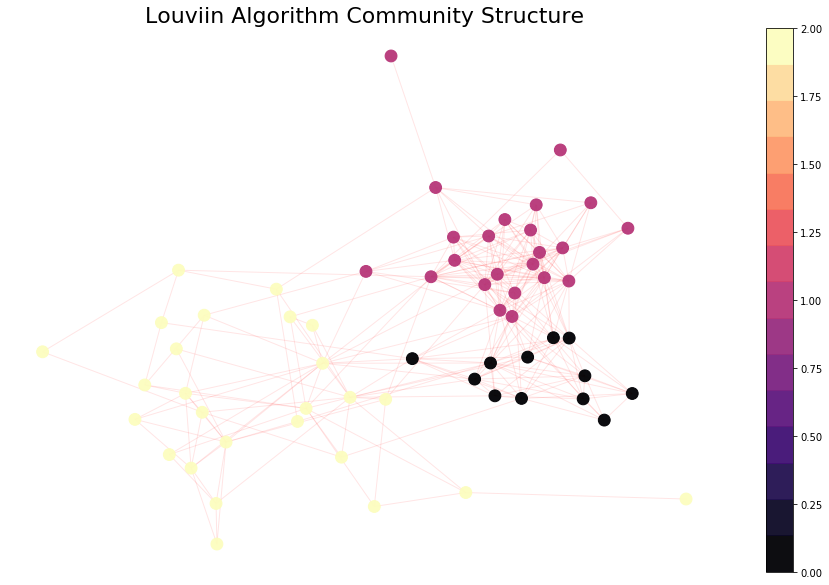

In [49]:
import community
import matplotlib.pyplot as plt
#partition = community.best_partition(com_graph)

values = [partition.get(node) for node in com_graph.nodes()]
values=[partition.get(node) for node in com_graph.nodes()]
plt.rcParams['figure.figsize']= [16, 10]
measure_name = "Louviin Algorithm Community Structure"
pos = nx.spring_layout(com_graph, k=0.2, iterations=20)
nodes_plot=nx.draw_networkx_nodes(com_graph, pos, node_size=140, label=True, cmap=plt.get_cmap('magma', len(com_graph.nodes())/4),node_color=values, alpha=0.95)
edges_plot=nx.draw_networkx_edges(com_graph, pos, edge_color='r', alpha=0.1)
plt.title(measure_name, fontsize=22, fontname='Arial')
plt.colorbar(nodes_plot)
plt.axis('off')
plt.show()

In [50]:
community.modularity(partition, com_graph)

0.42233918128654974

In [51]:
partition = sorted(partition.items(), key=lambda kv: kv[1], reverse=False)

In [52]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in partition:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (mod_texts[word])
        current=cluster
    else:
        print (mod_texts[word])

--------------cluster 0------------ 
 
That is pretty significant again if you are a financial alyst or anybody who who is excel guru but lacks the sequel knowledge learning sequel might be the next step for you to really progress your career and I get to find opportunity for a high job along with the higher potential see sought after skills by that are hiring this makes sense given the on alytics and the growth of data.
So would not apply as that are looking for more more individuals with have talent to a tree data on a database using sheet and know what to do with it along with the career audience and reasons for learning another reason that you might want want to see is because it enables you to get an answer to any questions that you have if you an inquisitive person and want to know as much as possible about your business.
But happen he eliminate that crashing by writing a queries one building type those code or script and want to get again the database that system is designed to 

In [53]:
com_graph.number_of_edges()

285

In [54]:
tg.number_of_edges()

1891

# Redefine the resulatant communities 

In [55]:
clusters = []
temp = []
prev_com = 0
for word,cluster in partition:
    if prev_com==cluster:
        temp.append(word)
        #print (temp)
    else:
        clusters.append(temp)
        temp = []
        prev_com = cluster
        temp.append(word)

In [56]:
timerange = []
temp = []
for index, cluster in enumerate(clusters):
    temp= []
    for sent in cluster:
        temp2 = [(sentence,start_time,user) for sentence,start_time,user in segment_contents.values() if mod_texts[sent] in sentence]
        if len(temp2)!=0:
            temp.append(temp2[0])
    if len(temp)!=0:
        temp = sorted(temp,key=lambda kv: kv[1])
        timerange.append(temp)
    else:
        print (cluster)

In [57]:
timerange_detailed = []
temp = []
flag = False
pims = {}
index_pim = 0
index_segment = 0
for index,com in enumerate(timerange):
    temp = []
    flag = False
    #print ("-----community-----", index)
    for (index1,(sent1,time1,user1)), (index2,(sent2,time2,user2)) in zip(enumerate(com[0:]),enumerate(com[1:])):
        if sent1!=sent2:
            #print (time1, time2, (time2-time1).seconds)
            if ((time2-time1).seconds<=240):
                if not flag:
                    pims[index_pim] = {'segment'+str(index_segment):[sent1,time1,user1]}
                    index_segment+=1
                    temp.append((sent1,time1,user1))
                #else:
                    #print ('removing',time1, time2)
                    #temp.pop()
                pims[index_pim]['segment'+str(index_segment)] = [sent2,time2,user2]
                index_segment+=1
                temp.append((sent2,time2,user2))
                flag=True
            else:
                #print (time2, time1)
                if flag==True:
                    index_pim+=1
                    index_segment=0
                flag=False
    if flag==True:
        index_pim+=1
        index_segment=0
    #print ("-----timeRange-----\n", [j for i,j,k in temp])
    timerange_detailed.append(temp)            

## Redefing the resultant communities using different approach (NA)

In [ ]:
timerange = []
temp = []
for index, cluster in enumerate(clusters):
    temp= []
    for sent in cluster:
        temp2 = [(sentence,start_time,user, [index]) for sentence,start_time,user in segment_contents.values() if mod_texts[sent] in sentence]
        if len(temp2)!=0:
            temp.append(temp2[0])
    if len(temp)!=0:
        temp = sorted(temp,key=lambda kv: kv[1])
        timerange.append(temp)
    else:
        print (cluster)

In [ ]:
flattened_timerange = sorted([sent for com in timerange for sent in com], key= lambda kv: kv[1])

In [ ]:
flattened_timerange[29]

In [ ]:
# ft_re = []
# for (index1,sent1), (index2, sent2) in zip(enumerate(flattened_timerange),enumerate(flattened_timerange)):
#     if  sent1[1]==sent2[1]:
#         if len(ft_re)!=0 and ft_re[-1][1] == sent1[1]:
#             temp = []
#             temp.extend([[ft_re[-1][-1], sent1[-1], sent2[-1]]])
#             print (temp)
#             tot_com = list(set(temp))
#             ft_re.pop()
#             ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
#         else:
#             tot_com = list(set([sent1[-1], sent2[-1]]))
#             ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
#     else:
#         if ft_re!=[] and ft_re[-1][1] == sent1[1]:
#             tot_com = list(set([ft_re[-1][-1], sent1[-1]]))
#             ft_re.pop()
#             ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
#         else:
#             ft_re.append(sent1)
            
ft_re = []
tot_com = []
flag=False
for index1, sent1 in enumerate(flattened_timerange):
    if flag==True:
        if index1!=j:
            continue
        else:
            flag=False
    if flag==False:
        for index2, sent2 in enumerate(flattened_timerange):
            if index2>index1:
                if sent1[1]==sent2[1]:
                    if flag==False:
                        tot_com.extend([sent1[-1][-1],sent2[-1][-1]])
                        flag=True
                    else:
                        tot_com.extend([sent2[-1][-1]])
                        if index2==(len(flattened_timerange)-1):
                                tot_com = max(set(tot_com), key = tot_com.count) 
                                ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
                else:
                    if flag==True:
                        tot_com = max(set(tot_com), key = tot_com.count)
                        ft_re.append((sent1[0],sent1[1],sent1[2],tot_com))
                        j = index2
                    else:
                        ft_re.append(sent1)
                        flag = False
                    tot_com = []
                    break

In [ ]:
ft_re

# Alter communities based on time range and get Keyphrases

In [58]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

keyphrase_text = ""
keyphrases_list = []
keyphrases = []
for index_pim in pims.keys():
    keyphrase_text = ""
    for seg in pims[index_pim]:
        if seg != "keyphrase":
            keyphrase_text += (' ' + pims[index_pim][seg][0])
    gr = GraphRank()
    tp = TextPreprocess()
    utils = GraphUtils()

    original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(keyphrase_text, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

    word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

    keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree')
    pims[index_pim]['keyphrase'] = [phrases for phrases, score in keyphrases]

In [59]:

yet_to_combine = []
need_to_remove = []
for index1,i in enumerate(pims.keys()):
    for index2,j in enumerate(pims.keys()):
        if index1!=index2:
            if pims[i]['segment0'][1] >= pims[j]['segment0'][1] and pims[i]['segment0'][1] <= pims[j]['segment'+str(len(pims[j].values())-2)][1]:
                if (j,i) not in yet_to_combine and i not in need_to_remove and j not in need_to_remove:
                    yet_to_combine.append((i,j))
                    need_to_remove.append(i)

In [60]:
for i,j in yet_to_combine:
    for k in pims[i]:
        if k!="keyphrase":
            if pims[i][k] not in pims[j].values():
                pims[j]['segment'+str(len(pims[j].values())-1)] = pims[i][k]
                #print (pims[i][k])
                continue
        else:
            extra_keyphrase = list(set(pims[i]['keyphrase'] + pims[j]['keyphrase']))
            pims[j]['keyphrase']=extra_keyphrase

In [61]:
for i in need_to_remove:
    pims.pop(i)

In [62]:
for i in pims.keys():
    print ("\n\n\nPIMs ", i)
    print ("\n\nDiscussion:\n\n ")
    for seg in pims[i]:
        if seg!="keyphrase":
            print (pims[i][seg][1], " ", pims[i][seg][0],"\n")
    print ("Keyphrases:\n\n ", pims[i]['keyphrase'])




PIMs  1


Discussion:

 
2019-07-02 11:27:54   Were going to be talking about why is many people as possible should be learning sequel or stand structure through we language and it is the primary language responsible for managing data and data structures contained within relational database systems. So anytime you are trying to retrieve data from a database and data database or make any modifications the data structures you are probably going to using some there of the sequel or T language. Let is dig into the first reason why I believe you should our sequel first turn some great body the potential for somebody with strong seamless skills. That is pretty significant again if you are a financial alyst or anybody who who is excel guru but lacks the sequel knowledge learning sequel might be the next step for you to really progress your career and I get to find opportunity for a high job along with the higher potential see sought after skills by that are hiring this makes sense given th

## testing topic modelling with LDA (NA)

In [ ]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in new_text]
#doc_clean = [clean(new_text[1]).split()]

In [ ]:
doc_clean

In [ ]:
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [ ]:
print(ldamodel.print_topics())

## Testing keyphrase for the timerange (NA)

In [32]:
pims = {
	"0": {
		"segment0": ["Like my per month to date most likely as we excuse into which we can that be better more consistent but General aw strategy what they say is have one Lambda the internet coming HTML segment notify is attached a general hook for the data uploaded the Lambda function who associate to the S3 bucket and have that pan out all other language like be a dispatcher. Yeah, thats.", "2019-06-28T06:16:58Z", "2982d23c-1e59-476d-88c8-a42376324142", "ebe8604a02c84952bb7ea9dfccd6c1df"]
	},
	"1": {
		"segment0": ["From by will sync up offline first trusting watertight preview will move manually create a bucket in staging environment and try to use it for testing but what I am expecting is not be a big change. What we what we can do is we can we can remove that CD and table itself from the database because the student table and other other things are actually only used for you know, this sets these things so we give you can remove them. So we will now will have a less overhead even in the future. So because after this change we are we are never going to use the stimuli. and.", "2019-06-28T06:11:11Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "0ef8d453e7bb41d3bd11153827df076a"]
	},
	"2": {
		"segment0": [
			["All right create an issue. Well track it should be a small thing even in the back end to handle. Yeah, I will see if I can look into it today."], "2019-06-28T05:35:58Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "f2d6bb774d5f4649b2e4f15bf07052ad"
		],
		"segment1": [
			["Nothing was done. Headmistress, I would wear black in the public Channel. We need to prompt Channel Minds. Also, I will check with Rashon thundergun. It was another."], "2019-06-28T05:39:19Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "418c719a0f5e4888b242df011e818aa3"
		],
		"segment2": [
			["And updated methods for that which I take do too. Okay. Yeah, I will look into that."], "2019-06-28T05:39:35Z", "d65899ed-e47e-4611-8c2c-59b154ff6a3f", "136b9ea1ccaf461facc5e7953a520ff6"
		]
	},
	"3": {
		"segment0": [
			["Its similar than better to go with S3. If GitHub is not giving you just artifact reading scope or something which release artifact reading Scopes even then it can be weird because if we keep tagging or create a good stuff that are not Jesus files are also generated. We need to prevent them from able to downloading do not also even if they do not we have to protect the code right should not be vulnerability this this take that what is the effort to from Reading from your front door if Jacob does give you anything fixed capacity?. ."], "2019-06-28T05:46:56Z", "2982d23c-1e59-476d-88c8-a42376324142", "8c4e8716db754f82b1ed36c449fa15a3"
		],
		"segment1": [
			["Another markers with calibration issue. I will also take a look on the back end. I know that we have to trim the edges to remove the flashin but I do think that if someone puts a empty space between two sentences that can cause an issue. I will just go check. Why is that occurring and see if it is something easy to pick up and then the back end also?."], "2019-06-28T05:50:04Z", "2982d23c-1e59-476d-88c8-a42376324142", "3c74a71652394d65abed891a412c008d"
		]
	},
	"4": {
		"segment0": [
			["You things on whether can we go eat on to Lambda or whether she should whether it should be based on the current key phrase. Maybe we will just take it off way, or I will talk to Sasha Hank and understand and get those details. We did have some plans to move it along."], "2019-06-28T05:57:22Z", "92b4588f-74cc-42f0-bf6d-eec0b6198ade", "6b474e34b42a4514b7689a378bc47c66"
		],
		"segment1": [
			["Between making calls on Tims and waiting on the one that comes last. Yeah that still happen because we will have to wait on the consensus of the what we need to do again is somewhat more on the cause they custom server is not doing anything and then it out into my you are still paying for the execution of the Pim. Lambda looks right at is one thing you can reduce but also the fact that we are right now waiting on Transit segment to complete I think within being the change we will need to wait on transcript second segment to be analyzed. Those are the events that trigger are some regeneration. So if it makes it and because that tramp is segment competed in already in the event of are acting on making this switch to the next most relevant is not a big problem. So it is more even driven so we do not need to wait on okay. Okay. Yeah, and then on the."], "2019-06-28T06:00:48Z", "2982d23c-1e59-476d-88c8-a42376324142", "f5c2855a681c40c8b5a77a85c5c0fd6d"
		],
		"segment2": [
			["Loved it. Thats fine. For now. I think you do. I think once you go to production, we need to figure out a way eventually to not lock sensitive information like transcript segment data Etc. And that will cause some you know issues still doing that. So but ceasing to your fine, too. Yeah."], "2019-06-28T06:02:50Z", "2982d23c-1e59-476d-88c8-a42376324142", "f56de51245ce4fa69c6628e5dc066369"
		],
		"segment3": [
			["Make a contained environment. You cannot specify the requirements separately and then all the executable file separately so that you can put the files as layers. I was just trying to do that, but I could not find it in the process of doing a trigger. If so, why?."], "2019-06-28T06:03:45Z", "f6b27e4a-ad4f-42b3-ac18-e09ec396685b", "4fddeb333fe745cdac8ee41d5785d0ba"
		],
		"segment4": [
			["I think when cat had reduced it to Fighters, I think Sicilian fighter he moved to by Torchlight and side by and all the mines and this one. So overall I think the thing got to do but we ended up using layers so we might be can end up adding both the layers for five dots by touch light and maybe scifi known by all the psychic number like it has layers and learning anything network accessible routes like that, but if sound 50mb."], "2019-06-28T06:06:36Z", "2982d23c-1e59-476d-88c8-a42376324142", "cc29605c0446480f8ace87c4d6593d8a"
		],
		"segment5": [
			["So currently was just working on the refactoring of bug book printing that is done basically it is in like the record reviews review comments have to just address it so apart from the doe those comments look straight forward or should not be a bigger big thing is basically so the other part is the pims part the the pins which are not seen in the mix does not constitute the last last few segments the meeting right? So that issue if started working on it like probably a bit Monday should be able to send the send it for review that code. Okay. Yeah that I maybe I will have to ask like more technical things. I will have to ask like if there is anything which I am missing missing I will call you again."], "2019-06-28T06:08:07Z", "6e8408ce-1072-4209-9e82-945701c7b86c", "439f3d6209184e19a7de54c59a8c4533"
		],
		"segment6": [
			["Make a contained environment. You cannot specify the requirements separately and then all the executable file separately so that you can put the files as layers. I was just trying to do that, but I could not find it in the process of doing a trigger. If so, why?."], "2019-06-28T06:03:45Z", "f6b27e4a-ad4f-42b3-ac18-e09ec396685b", "4fddeb333fe745cdac8ee41d5785d0ba"
		]
	},
	"5": {
		"segment0": ["But we we have done it. We have done it only from our office and I am not confused coming from that one will because people in the calls are like variables XnumberX  scholar two persons called Waterloo. We visited a real scenario kind of thing according a minimum XnumberX people per call because we just need to load test it and because it is normal generous mood worth but under the cave under the load, how does how its behaving that we need to check? Yeah.", "2019-06-28T06:21:56Z", "b6db6d45-1a71-41e7-bc16-ae330f655c38", "b573665bbeae49bdb26020751122dfc1"]
	}
}

In [40]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

keyphrase_text = ""
keyphrases_list = []
keyphrases = []
for index_pim in pims.keys():
    keyphrase_text = ""
    for seg in pims[index_pim]:
        if seg != "keyphrase":
            keyphrase_text += (' ' + ''.join([i for i in pims[index_pim][seg][0]]))
            print (keyphrase_text)
    gr = GraphRank()
    tp = TextPreprocess()
    utils = GraphUtils()

    original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(keyphrase_text, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

    word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

    keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree')
    pims[index_pim]['keyphrase'] = [phrases for phrases, score in keyphrases]

 Like my per month to date most likely as we excuse into which we can that be better more consistent but General aw strategy what they say is have one Lambda the internet coming HTML segment notify is attached a general hook for the data uploaded the Lambda function who associate to the S3 bucket and have that pan out all other language like be a dispatcher. Yeah, thats.
 From by will sync up offline first trusting watertight preview will move manually create a bucket in staging environment and try to use it for testing but what I am expecting is not be a big change. What we what we can do is we can we can remove that CD and table itself from the database because the student table and other other things are actually only used for you know, this sets these things so we give you can remove them. So we will now will have a less overhead even in the future. So because after this change we are we are never going to use the stimuli. and.
 All right create an issue. Well track it should be a 

 But we we have done it. We have done it only from our office and I am not confused coming from that one will because people in the calls are like variables XnumberX  scholar two persons called Waterloo. We visited a real scenario kind of thing according a minimum XnumberX people per call because we just need to load test it and because it is normal generous mood worth but under the cave under the load, how does how its behaving that we need to check? Yeah.


In [41]:
pims

{'0': {'segment0': ['Like my per month to date most likely as we excuse into which we can that be better more consistent but General aw strategy what they say is have one Lambda the internet coming HTML segment notify is attached a general hook for the data uploaded the Lambda function who associate to the S3 bucket and have that pan out all other language like be a dispatcher. Yeah, thats.',
   '2019-06-28T06:16:58Z',
   '2982d23c-1e59-476d-88c8-a42376324142',
   'ebe8604a02c84952bb7ea9dfccd6c1df'],
  'keyphrase': ['html segment notify',
   'sxnumberx bucket',
   'lambda function',
   'general hook',
   'month',
   'dispatcher',
   'language',
   'consistent',
   'pan',
   'strategy',
   'data',
   'internet',
   'general']},
 '1': {'segment0': ['From by will sync up offline first trusting watertight preview will move manually create a bucket in staging environment and try to use it for testing but what I am expecting is not be a big change. What we what we can do is we can we can rem

## keyphrases comparision with word2vec (NA)

In [169]:
with open("../data/meetings_slack_embeddings.pkl","rb") as f:
    emb = pickle.load(f)

In [181]:
nodea = 'sql'
nodea_fv = emb[nodea]
closest_match =[]
for nodeb in emb.keys():
    if nodeb!=nodea:
        diff = 1 - cosine(emb[nodeb], nodea_fv)
        closest_match.append((nodeb, diff))
closest_match_sorted = sorted(closest_match, key= lambda kv:kv[1], reverse=True)

In [182]:
closest_match_sorted[:5]

[('api', 0.6537092924118042),
 ('microsoft', 0.6197659373283386),
 ('drm', 0.6010190844535828),
 ('apis', 0.5922703146934509),
 ('ibm', 0.5897950530052185)]

In [215]:
import pandas

df = pandas.read_csv('../data/query_resultsync2.csv', index_col=False, header=0);

import json
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp
data= {}

segment_contents = {}
texts = ''

for index,segment in enumerate(df['value'].tolist()):
    data = json.loads(segment)
    if "google" not in data['transcriber'] and data['originalText']!='':
    #if "google" not in data['transcriber']:
        texts+= (' ' + data['originalText'])
        segment_contents[index]= [' '.join(tp.preprocess(data['originalText'], stop_words=False, remove_punct=False)),formatTime(data['startTime'], True), data['spokenBy']]
        

In [221]:
texts

" Okay. It's. All the changes accomplished complete on Subscription on two things I noticed test was that I IP address in the main link. So for that we I'll discuss and and. Very and so that that won't happen and will that for the we need the then function that website video only allen. And then we be kind of whatever they there is something for. But I saying so at so that they know that it's it's if we can all ask for okay have app. Yeah, right right? Right? Yeah yeah. Okay? I'll do that okay. So that is one I think that's it right anyone else think of anything else before we just upload it and make it ready. Are those are okay only. Yeah, sorry, the only thing to be is is that we don't in that and the myself the old spaces. I don't know if that will cause a problem or not I of okay. What will do for is when make all the changes in that site you know website ether larger Io today and then we'll ask Colin do take one quick pa*s and then if everything works. Well more go life. Okay. So 

In [216]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

gr = GraphRank()
tp = TextPreprocess()
utils = GraphUtils()

original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(keyphrase_text, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

#keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree')
#pims[index_pim]['keyphrase'] = [phrases for phrases, score in keyphrases]

In [217]:
com_graph = GraphRank()
nodes_list = []
for indexa, nodea in enumerate(list(word_graph.nodes())):
    for indexb, nodeb in enumerate(list(word_graph.nodes())):
        if indexb>indexa:
            if nodea not in emb.keys() or nodeb not in emb.keys():
                #nodes_list.append((nodea,nodeb,0.5))            
                continue
            nodes_list.append((nodea,nodeb,cosine(emb[nodea],emb[nodeb])))
#print (*nodes_list, sep="\n")
nodes_list_sorted = sorted(nodes_list, key=lambda kv: kv[2], reverse=True)

nodes_list = nodes_list_sorted[:math.ceil(len(nodes_list_sorted)*0.05)+1]

com2_graph = nx.Graph()
for nodea,nodeb, weight in nodes_list:
    com2_graph.add_edge(nodea,nodeb)

partition = community.best_partition(com2_graph)

In [218]:
community.modularity(partition, com2_graph)

0.39149034570470576

In [219]:
partition = sorted(partition.items(), key=lambda kv: kv[1], reverse=False)

In [220]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in partition:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (word)
        current=cluster
    else:
        print (word)

--------------cluster 0------------ 
 
good
double
address
ether
higher
--------------cluster 1------------ 
 
user
focused
team
today
word
reason
app
--------------cluster 2------------ 
 
slack
ip
topic
care
test
changes
time
--------------cluster 3------------ 
 
microsoft
left
final
account
week
perfect
easier
live
apps
party
--------------cluster 4------------ 
 
theory
pro
spaces
update
updates
deep
customer
link
fine
--------------cluster 5------------ 
 
guys
database
production
info
--------------cluster 6------------ 
 
friday
straightforward
transactions
colin
hours
label
problem
main
staging
interesting
tool
